# Week of 2025.07.21

## Last week
[Last week](https://paxtonsc.github.io/files/geophysics/volcano_project/weekly_notes/2025.07.16.infrasound.html) I looked into the diffusive error that we saw at the slip/atmosphere boundary. My conclusions from last week were the following. 

1. When we reduce the spatial discretization size to 0.1m, the velocity and slip graphs with atmosphere largely match the model with out atmosphere (which also roughly matches the lumped parameter model). However, even with 0.1m spacing we still can see a significant increase in density (and resulting decrease in sound speed) at the base of the 1D atmosphere. 

2. When we start the simulation at 2s (with the first 2s simulation without atmosphere), a `1m` discretization achieves a similar "accuracy" with the 0.1 m and atmosphere included for the full length of the simulation. 

3. For simulations without atmosphere, modeling the atmosphere as a constant 1e5 Pa likely results in incorrect pressure near the outlet. 

## High level goal
Let's remember, our high level goal is to create an accurate infrasound model of the eruption in a 2D mesh.

## Problems
Let's also review our problems, proceeding from general to specific.
1. When we model the 2D infrasound we get a result that is hard to validate.
2. When we simplify the problem to a toy model (with only gravity, sip weakening, viscous friction, and pressure) we see that pairing the atmosphere results in significant numerical diffusion. 

## Plan 
1. Let's first verify that with this toy problem, when we increase the resolution sufficiently we are able to generate results (conduit model + 1D atmosphere model) that can be validated by (a) lumped parameter model for the melt (b) simple relation between pressure and velocity $\Delta p = \rho c \Delta v$. 

2. Once that is done, let's try to model the toy problem with a 2D mesh field for the atmosphere. We would like similarly show that the the melt is still accurately represented by the lumped parameter model and that the 2D atmosphere is accurately modeled by a monopole source term. 

## Goals 
- [x] Model toy example with  0.1m order 1 atmosphere. Check to see if that resolves the diffusion issue. 
- [x] Write a new animation class to display both the melt and the atmosphere in a single simulation. 
- [x] Attach the updated conduit flow model to the 1D atmosphere. Simulate with 0.1m accuracy and see how much numerical diffusion is happening. Compare result with analytical solution that just related pressure and velocity.  
- [] Run high fidelity sim of atmosphere in both 2d and 1d. Is there a way to compare 1D simulation to an analytical solution.
- [] Apply lighthill integral and see how plausible the results are. What bounds of integration should I use? 


## Review of size of mesh and numerical diffusion. 
Let's start by reviewing the size of the mesh and the relationship with numerical diffusion from last week. 


## Notes from Eric
- Eric agrees that we should come up with some metric for how much diffusive error is accetable. " The guiding question should always be, why are we doing these simulations? What hypothesis are we trying to test? What features in the data are diagnostic of some process we're interested in, and how can we get our simulations to be sufficiently accurate to resolve and reproduce those features?"
- Reproduce this analysis with Mario's current "best" model. 
-  Also try to figure out if they create issues. Do they delay an infrasound wave that would otherwise exit the vent? If so, that could have big implications for our ability to model infrasound. This is currently the thing that concerns me the most (as your workflow seems to have eliminated the leading negative pressure pulse).
- Eric suggests I consider updating the BC of the model without atmosphere to look something like: p_vent - rho_atm*c_atm*v_vent = p_atm. Hopefully when we move to 2D we do not see this pressure discrepency. 


## Notes from Mario:
- Working on reducing exsolution by increasing exsolution time scale. [Paper](https://pubs.geoscienceworld.org/gsl/books/edited-volume/1534/chapter/107251504/Modelling-of-conduit-flow-dynamics-during)
- Also working through trade between viscosity and drag. 
- More drag = more high frequencies. 

## Outstanding questions 
- Validation method for 1D atmosphere? 
- Low sound of speed at melt/atmosphere boundary? 
- Size of volume required for lighthill stress tensor? 


In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func, get_quantities_at_conduit_exit, get_quantities_at_all_space
from helper_code.animate import animate_conduit_pressure, animate_melt_atmosphere_combination
from helper_code.analytical_solution import get_lumped_solution

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_conduit"

ITERS = 50
D_ITERS = 1
END_TIME = 10
C0 = 320 # m/s at 5000m

In [4]:
t_analytical, slip_analytical, u_analytical = get_lumped_solution(
    K=1e9,
    L_melt=950,
    tau_p=1e6,
    tau_r=0,
    R=10,
    L_plug=50,
    rho=2.6e3,
    mu=5e4,
    D_c=3,
    C=600,
    p0=11.5e6,
    p_atm=1e5,
    t_end=10
)

file_name = "short_plug_v0"
folder_name = "simple_conduit_1d_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_w_atm, p_quail_w_atm, slip_quail_w_atm, u_quail_w_atm, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "short_plug_v1"
folder_name = "simple_conduit_1d_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_w_atm_1, p_quail_w_atm_1, slip_quail_w_atm_1, u_quail_w_atm_1, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "short_plug_v2"
folder_name = "simple_conduit_1d_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_w_atm_2, p_quail_w_atm_2, slip_quail_w_atm_2, u_quail_w_atm_2, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "short_plug_1m"
folder_name = "simple_conduit_no_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail, p_quail, slip_quail, u_quail, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "order1_atm_01m"
folder_name = "simple_conduit_1D_atmosphere_linear_IC"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_order1_01m, p_quail_order1_01m, slip_quail_order1_01m, u_quail_order1_01m, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=9, compute_temp=True, conduit_index=-1
)

## Review results from toy simulation

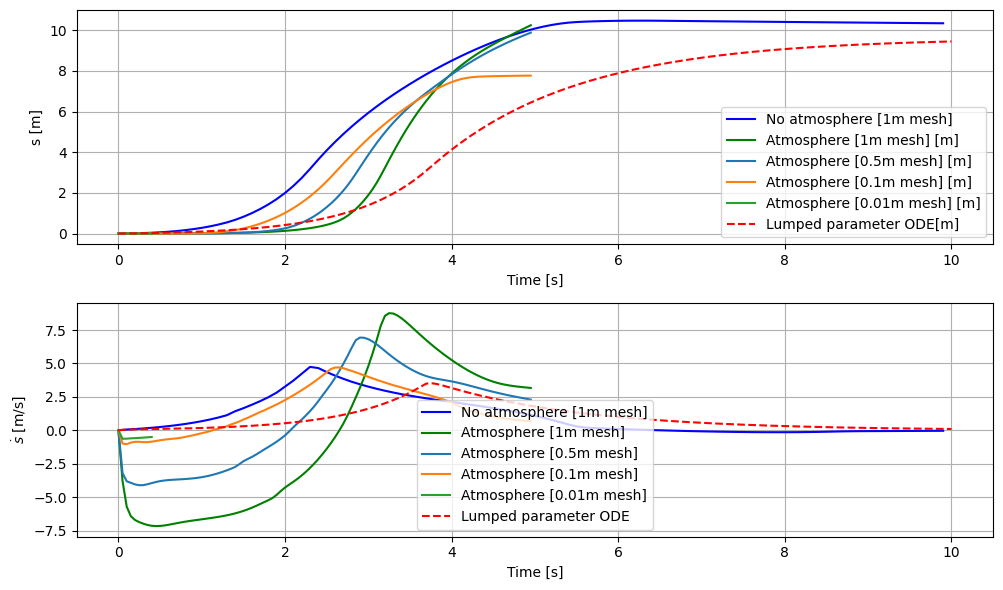

In [5]:
# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t_quail, slip_quail, "b-", label="No atmosphere [1m mesh]")
plt.plot(t_quail_w_atm, slip_quail_w_atm, "g-", label="Atmosphere [1m mesh] [m]")
plt.plot(t_quail_w_atm_1, slip_quail_w_atm_1, label="Atmosphere [0.5m mesh] [m]")
plt.plot(t_quail_w_atm_2, slip_quail_w_atm_2, label="Atmosphere [0.1m mesh] [m]")
plt.plot(t_quail_order1_01m, slip_quail_order1_01m, label="Atmosphere [0.01m mesh] [m]")
plt.plot(t_analytical, slip_analytical, "r--", label="Lumped parameter ODE[m]")
plt.xlabel("Time [s]")
plt.ylabel("s [m]")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_quail, u_quail, "b-", label="No atmosphere [1m mesh]")
plt.plot(t_quail_w_atm, u_quail_w_atm, "g-", label="Atmosphere [1m mesh]")
plt.plot(t_quail_w_atm_1, u_quail_w_atm_1, label="Atmosphere [0.5m mesh]")
plt.plot(t_quail_w_atm_2, u_quail_w_atm_2, label="Atmosphere [0.1m mesh]")
plt.plot(t_quail_order1_01m, u_quail_order1_01m, label="Atmosphere [0.01m mesh]")
plt.plot(t_analytical, u_analytical, "r--", label="Lumped parameter ODE")
plt.xlabel("Time [s]")
plt.ylabel(r"$\dot{s}$ [m/s]")
plt.grid(True)
plt.legend()

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/lumped_parameter_model.png")
plt.tight_layout()
plt.show()

## Review full simulation of high spatial fidelity simulation of melt + atmosphere 

Let's review the behavior of the melt + atmosphere in the model with 0.1m spatial resolution. 

- [ ] Why does the sound speed get so low at the boundary? 
- [ ] What is causing that? 
- [ ] Are the low sound speeds causing problems?

## Metric for how much diffusive error is Ok

- [ ] Why are we doing these simulations? The goal is to create a infrasound simulation that is accurate enough that we can use it in conjunction with lighthill stress tensor to predict pressure at a distance volcano. 
- [ ] What hypothesis are we trying to test? 
- [ ] What features in the data are diagnostic of some process we're interested in, and how can we get our simulations to be sufficiently accurate to resolve and reproduce those features?

In [75]:
folder_name = "simple_conduit_1D_atmosphere_linear_IC"
melt_file_name = "short_plug_order1_atm_1m"
atmosphere_file_name = "vertical_atmosphere_01_atm1"
melt_solver_func = get_local_solver_from_index_func(folder_name, melt_file_name)
atmosphere_solver_func = get_local_solver_from_index_func(folder_name, atmosphere_file_name)

iters = 100

ani = animate_melt_atmosphere_combination(
    melt_solver_func,
    atmosphere_solver_func,
    iterations=100,
    d_iterations=10,
    y_min=-1000,
    y_max=1000,
    max_pressure=0.2,
    min_pressure=0,
    max_velocity=10,
    min_velocity=0,
    max_density=3e3,
    min_density=0,
    max_slip=20,
    min_slip=0,
)

HTML(ani.to_html5_video())

# Run Mario's best full model **with 2d atmosphere**. 


In [10]:
file_name = "tungurahua_no_atm_v0"
folder_name = "2025_07_21_eruption_sim"
iters = 100
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=4,
    viscosity_index=1,
    wall_friction_index=5,
    max_velocity=20,
    max_slip=60,
    max_tau=1.5,
    max_pressure=50,
    max_speed_of_sound=2000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
)

HTML(ani.to_html5_video())

## And **without** atmosphere

In [13]:
file_name = "tungurahua_atm_1m"
folder_name = "2025_07_21_eruption_sim"
iters = 100
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=4,
    viscosity_index=1,
    wall_friction_index=5,
    max_velocity=20,
    max_slip=60,
    max_tau=1.5,
    max_pressure=50,
    max_speed_of_sound=2000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
)

HTML(ani.to_html5_video())

In [45]:
file_name = "tungurahua_no_atm_v0"
folder_name = "2025_07_21_eruption_sim"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_tung_no_atm, p_tung_no_atm, slip_tung_no_atm, u_tung_no_atm, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "tungurahua_atm_1m"
folder_name = "2025_07_21_eruption_sim"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_tung_atm_1m, p_tung_atm_1m, slip_tung_atm_1m, u_tung_atm_1m, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "tungurahua_atm_5m"
folder_name = "2025_07_21_eruption_sim"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_tung_atm_5m, p_tung_atm_5m, slip_tung_atm_5m, u_tung_atm_5m, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=90, compute_temp=True, conduit_index=-1
)


folder_name = "2025_07_23_eruption_1d_atmosphere_sim"
file_name = "tungurahua_atm_1m"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_tung_atm_1m_1d, p_tung_atm_1m_1d, slip_tung_atm_1m_1d, u_tung_atm_1m_1d, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

## Compare conduit models with no-atmosphere/atmosphere1D/atmosphere3D 
- There does not appear to be a huge issue with diffusive error at the moment.
- Perhaps increasing the resolution to 1D was sufficient. 
- However, we do see a descrepancy between the pressure at 0m. That is likely a result of the model without atmosphere not properly including higher pressure. 

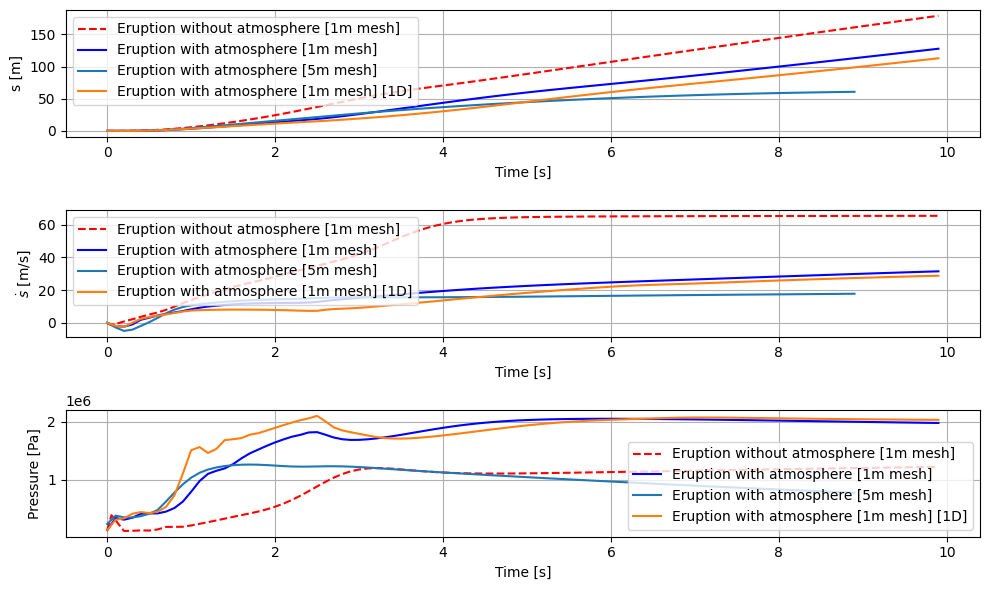

In [46]:
# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(t_tung_no_atm, slip_tung_no_atm, "r--", label="Eruption without atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m, slip_tung_atm_1m, "b-", label="Eruption with atmosphere [1m mesh]")
plt.plot(t_tung_atm_5m, slip_tung_atm_5m, label="Eruption with atmosphere [5m mesh]")
plt.plot(t_tung_atm_1m_1d, slip_tung_atm_1m_1d, label="Eruption with atmosphere [1m mesh] [1D]")
plt.xlabel("Time [s]")
plt.ylabel("s [m]")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_tung_no_atm, u_tung_no_atm, "r--", label="Eruption without atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m, u_tung_atm_1m, "b-", label="Eruption with atmosphere [1m mesh]")
plt.plot(t_tung_atm_5m, u_tung_atm_5m, label="Eruption with atmosphere [5m mesh]")
plt.plot(t_tung_atm_1m_1d, u_tung_atm_1m_1d, label="Eruption with atmosphere [1m mesh] [1D]")
plt.xlabel("Time [s]")
plt.ylabel(r"$\dot{s}$ [m/s]")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_tung_no_atm, p_tung_no_atm, "r--", label="Eruption without atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m, p_tung_atm_1m, "b-", label="Eruption with atmosphere [1m mesh]")
plt.plot(t_tung_atm_5m, p_tung_atm_5m, label="Eruption with atmosphere [5m mesh]")
plt.plot(t_tung_atm_1m_1d, p_tung_atm_1m_1d, label="Eruption with atmosphere [1m mesh] [1D]")
plt.xlabel("Time [s]")
plt.ylabel("Pressure [Pa]")
plt.grid(True)
plt.legend()

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/lumped_parameter_model.png")
plt.tight_layout()
plt.show()

## Review 1D atmosphere + latest volcano sim results. 

- [ ] I would like to have some sanity check here to see if the numerical model is plausible. What would that model look like? 

In [76]:
folder_name = "2025_07_23_eruption_1d_atmosphere_sim"
melt_file_name = "tungurahua_atm_1m"
atmosphere_file_name = "vertical_atmosphere_01_atm1"
melt_solver_func = get_local_solver_from_index_func(folder_name, melt_file_name)
atmosphere_solver_func = get_local_solver_from_index_func(folder_name, atmosphere_file_name)

iters = 100

ani = animate_melt_atmosphere_combination(
    melt_solver_func,
    atmosphere_solver_func,
    iterations=100,
    d_iterations=5,
    y_min=-1000,
    y_max=1000,
    max_pressure=0.13,
    min_pressure=0.07,
    max_velocity=100,
    min_velocity=0,
    max_density=3e3,
    min_density=0,
    max_slip=150,
    min_slip=0,
)

HTML(ani.to_html5_video())

## 3D Atmosphere animation

In [68]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

iterations = 100
# Assume solver2D_from is available as in the original code
solver2D_atm1 = get_local_solver_from_index_func("2025_07_21_eruption_sim", "test_infrasound_v1_atm1")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (-1e3, 1e3)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")
x1, p1_0= mdtools.downsample(solver2D_atm1(0), plot_qty="Pressure")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x1, p1= mdtools.downsample(solver2D_atm1(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x1, p1 - p1_0, clims)
    plt.title(f"Order 1: Pressure Field at t= {round(solver2D_atm1(frame).time)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, iterations, 4),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up


## Light hill stress tensor to predict pressure at sensor

In [50]:
import helper_code.lighthill as lighthill
import numpy as np
import matplotlib.tri as tri

def solver_from_2D(dom, i):
    solver_func = get_local_solver_from_index_func("2025_07_21_eruption_sim", f"test_infrasound_v1_atm{dom}")

    return solver_func(i)

# Prep interpolation grid
solver0 = solver_from_2D(1, 0)
physics = solver0.physics
base_x = np.linspace(0, 300, 200)
base_y = np.linspace(-200, 800, 200)
mg_x, mg_y = np.meshgrid(base_x, base_y, indexing="xy")

solver0_list = [solver_from_2D(dom_idx, 0) for dom_idx in [1]]
# Compute workload partition
ind_partition = [np.where(tri.Triangulation(
  solver.mesh.node_coords[...,0],
  solver.mesh.node_coords[...,1], 
  triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(mg_x.ravel(), mg_y.ravel()) != -1)[0]
  for solver in solver0_list]

# List of file indices to read
file_index_list = np.arange(0,iterations,1)

In [52]:
# Allocate union (joining all times) U, in spatially-flattened shape
U_union = np.nan * np.empty((file_index_list.size, *mg_x.ravel().shape, 8+physics.NDIMS))

for time_idx, file_idx in enumerate(file_index_list):

	# Load solvers for given time_idx
	solver_list = [solver_from_2D(dom_idx, file_idx) for dom_idx in [1]]

	for solver, _index_partition in zip(solver_list, ind_partition):
		# Identify physical position (x, y) of points to interpolate at with shape (npoints, 2)
		_phys_pos = np.stack(
			(mg_x.ravel()[_index_partition],
			mg_y.ravel()[_index_partition]),
			axis=1)
		# Identify element indices for all points to interpolate at
		elt_indices = tri.Triangulation(
			solver.mesh.node_coords[...,0],
			solver.mesh.node_coords[...,1], 
			triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(_phys_pos[:,0], _phys_pos[:,1])

		# Identify element node coordinates
		x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
		# Compute global physical-to-reference coordinate mapping
		ref_mapping = lighthill.compute_ref_mapping(x_tri)

		# Interpolate for each point using the correct element, writing to correct index in global U array
		for (write_idx, x_point, ie) in zip(_index_partition, _phys_pos, elt_indices):
			# For element containing point, compute reference coordinate of sampling point
			ref_coords_loc = np.einsum("ij, j -> i",
																ref_mapping[ie,...],
																x_point - x_tri[ie,0,:])
			# Evaluate basis at reference coordinate
			U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]))

			#U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]) + solver.state_coeffs[ie,1,:] * ref_coords_loc[0] + solver.state_coeffs[ie,2,:] * ref_coords_loc[1])

In [53]:
# Evaluate temperature using interpolated state, migrate to meshgrid shape (time_indices, mg_x.shape[0], mg_x.shape[1])
T_interp = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
yM = np.reshape(U_union[...,2:3] / rho, (file_index_list.size, *mg_x.shape))

t_range = np.linspace(0, 12.5, T_interp.shape[0])

In [54]:
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
u = U_union[:,:,3:4] / rho
v = U_union[:,:,4:5] / rho

# Pull rho, u, v
mg_u = np.reshape(u, (file_index_list.size, *mg_x.shape))
mg_v = np.reshape(v, (file_index_list.size, *mg_x.shape))
mg_T = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p = np.reshape(physics.compute_variable("Pressure", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_rho = np.reshape(rho, (file_index_list.size, *mg_x.shape))
mg_c = np.reshape(physics.compute_variable("SoundSpeed", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p0 = mg_p[0,...]

In [55]:
# Grid dimensions
dx = np.diff(mg_x[0:1,:], axis=1)
dy = np.diff(mg_y[:,0:1], axis=0)
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]

# Grid-center differentiation
u_foldx = (0.5 * (mg_u[:,:,1:] + mg_u[:,:,:-1]))
u_foldy = (0.5 * (mg_u[:,1:,:] + mg_u[:,:-1,:]))
dudy = np.diff(u_foldx, axis=1) / dy
dudx = np.diff(u_foldy, axis=2) / dx

v_foldx = (0.5 * (mg_v[:,:,1:] + mg_v[:,:,:-1]))
v_foldy = (0.5 * (mg_v[:,1:,:] + mg_v[:,:-1,:]))
dvdy = np.diff(v_foldx, axis=1) / dy
dvdx = np.diff(v_foldy, axis=2) / dx

mg_c0 = mg_c[0,...]
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]
# Interior grid-center coordinates
int_x = center_x[1:-1,1:-1]
int_y = center_y[1:-1,1:-1]

In [56]:
# Evaluate matrix T
T00_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho
T01_nonlinear = np.zeros_like(mg_rho)
T10_nonlinear = np.zeros_like(mg_rho)
T11_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho

# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_nonlinear, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_nonlinear[:,1:,:] + T00_nonlinear[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_nonlinear[:,:,1:] + T11_nonlinear[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_nonlinear = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

In [57]:
# Evaluate matrix T
T00_inertial = mg_rho * mg_u * mg_u
T01_inertial = mg_rho * mg_u * mg_v
T10_inertial = mg_rho * mg_v * mg_u
T11_inertial = mg_rho * mg_v * mg_v

# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_inertial, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_inertial[:,1:,:] + T00_inertial[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_inertial[:,:,1:] + T11_inertial[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_inertial = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

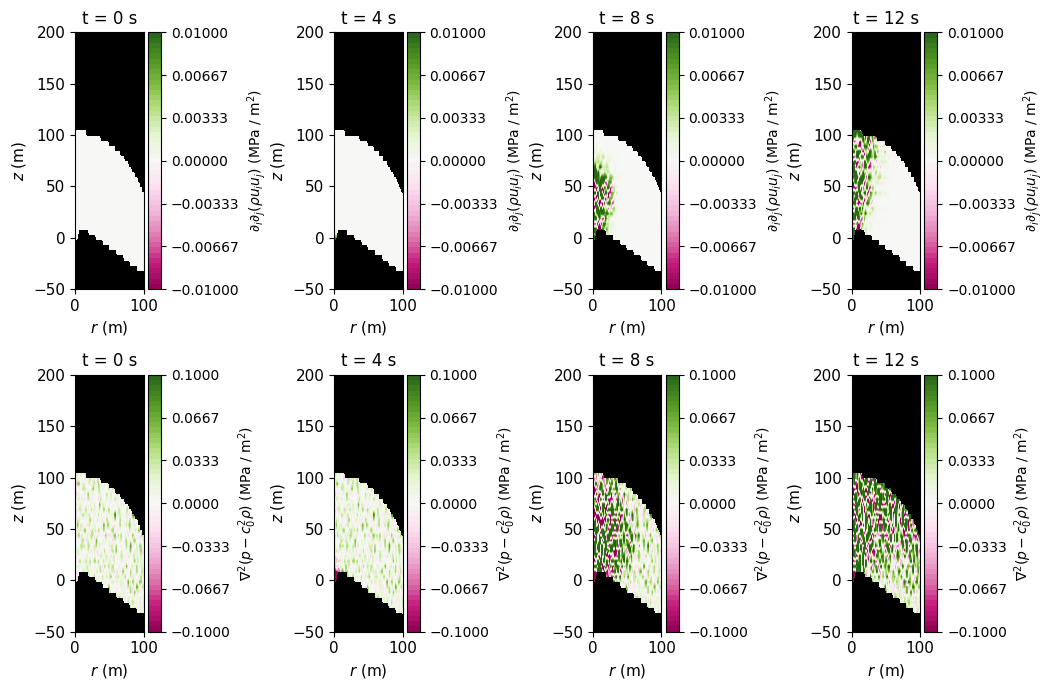

In [59]:
import matplotlib
fig, ax = plt.subplots(2, 4, figsize=(10.5,7))

levels = np.linspace(-1e4, 1e4, 50) / 1e6
# t_indices = [3, 9, 36, 72]
t_indices = [0, 33, 66, 99]

for i, t_ind in enumerate(t_indices):
  ax[0,i].set_facecolor("black")
  cf = ax[0,i].contourf(int_x, int_y, np.clip(dijTij_inertial[t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
  cb = fig.colorbar(cf, label=r"$\partial_i \partial_j (\rho u_i u_j)$ (MPa / m${}^2$)",
                    # format=matplotlib.ticker.FormatStrFormatter('%.3e')
                    )
  ax[0,i].set_xlim(0, 100)
  ax[0,i].set_ylim(-50, 200)
  #ax[0,i].set_aspect('equal')
  ax[0,i].set_xlabel("$r$ (m)")
  ax[0,i].set_ylabel("$z$ (m)")
  curr_ax = ax[0,i]
  for item in ([curr_ax.xaxis.label, curr_ax.yaxis.label] +
                curr_ax.get_xticklabels() + curr_ax.get_yticklabels()):
    item.set_fontsize(11)
  cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
  ax[0,i].set_title(f"t = {round(t_range[t_ind])} s")
  # cb.ax.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%e'))

# fig.tight_layout()
  
# fig, ax = plt.subplots(1, 3, figsize=(8.5,3.5))

levels = np.linspace(-1e5, 1e5, 50) / 1e6
# t_indices = [3, 9, 36, 72]
t_indices = [0, 33, 66, 99]

for i, t_ind in enumerate(t_indices):
  ax[1,i].set_facecolor("black")
  cf = ax[1,i].contourf(int_x, int_y, np.clip(dijTij_nonlinear[t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
  cb = fig.colorbar(cf, label=r"$\nabla^2 (p - c_0^2 \rho)$ (MPa / m${}^2$)",
                    # format=matplotlib.ticker.FormatStrFormatter('%.3e')
                    )
  ax[1,i].set_xlim(0, 100)
  ax[1,i].set_ylim(-50, 200)
  #ax[1,i].set_aspect('equal')
  ax[1,i].set_xlabel("$r$ (m)")
  ax[1,i].set_ylabel("$z$ (m)")
  curr_ax = ax[1,i]
  for item in ([curr_ax.xaxis.label, curr_ax.yaxis.label] +
                curr_ax.get_xticklabels() + curr_ax.get_yticklabels()):
    item.set_fontsize(11)
  cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
  ax[1,i].set_title(f"t = {round(t_range[t_ind])} s")
  # cb.ax.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%e'))

fig.tight_layout()
plt.draw()
plt.savefig(f'{BASE_PATH}/volcano_sims/notebooks/charts/lighthill_tensor_double_divergence.png')

In [66]:
import helper_code.lighthill as lighthill

source = dijTij_inertial + dijTij_nonlinear

print(source.shape)

x_obs = (2000, -1000, 0)
c0 = 320 # m/s roughly the speed of sound in air at 5000m in elevation
atmosphere_solid_angle = 4 * np.pi * (2/3)

X = int_x[0]
Y = int_y[:,0]

X = np.linspace(-100, 100, 20)
Y = np.linspace(0, 100, 20)
Z = np.linspace(-100, 100, 20)

points = (t_range, int_y[:,0], int_x[0])

pressure_obs = lighthill.calculate_pressure_as_volume_integral(X, Y, Z, file_index_list, x_obs, points, source, t_range, int_x[0][-1], c0)

(100, 197, 197)
DV size is 583.1753899985422
Finished time index 0 of 100
Finished time index 10 of 100
Finished time index 20 of 100
Finished time index 30 of 100
Finished time index 40 of 100
Finished time index 50 of 100
Finished time index 60 of 100
Finished time index 70 of 100
Finished time index 80 of 100
Finished time index 90 of 100
Number of contributions: 192076
r average: 2252.1940839950003
Max source value: [143533.8422217706]


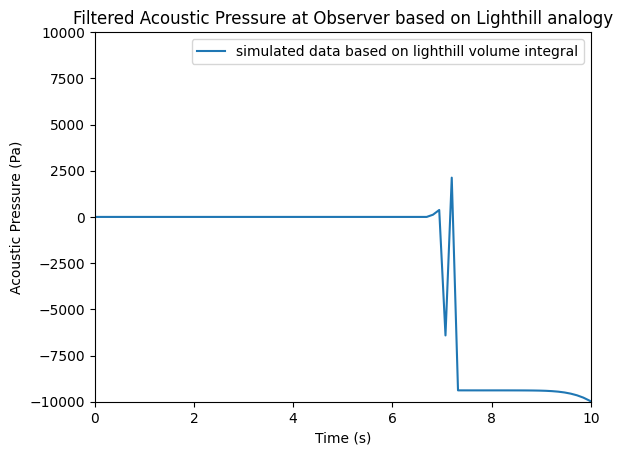

In [77]:
plt.plot(t_range, pressure_obs, label="simulated data based on lighthill volume integral")
plt.xlabel('Time (s)')
plt.ylabel('Acoustic Pressure (Pa)')
plt.title('Filtered Acoustic Pressure at Observer based on Lighthill analogy')
plt.xlim(0, 10)
plt.ylim(-1e4, 1e4)
plt.legend()

## A1. Review 3D mesh

/Users/paxton/git/quail_volcano/src

Points: (1842, 3)
Cells: dict_keys(['line', 'triangle'])
Cell Sets: {}


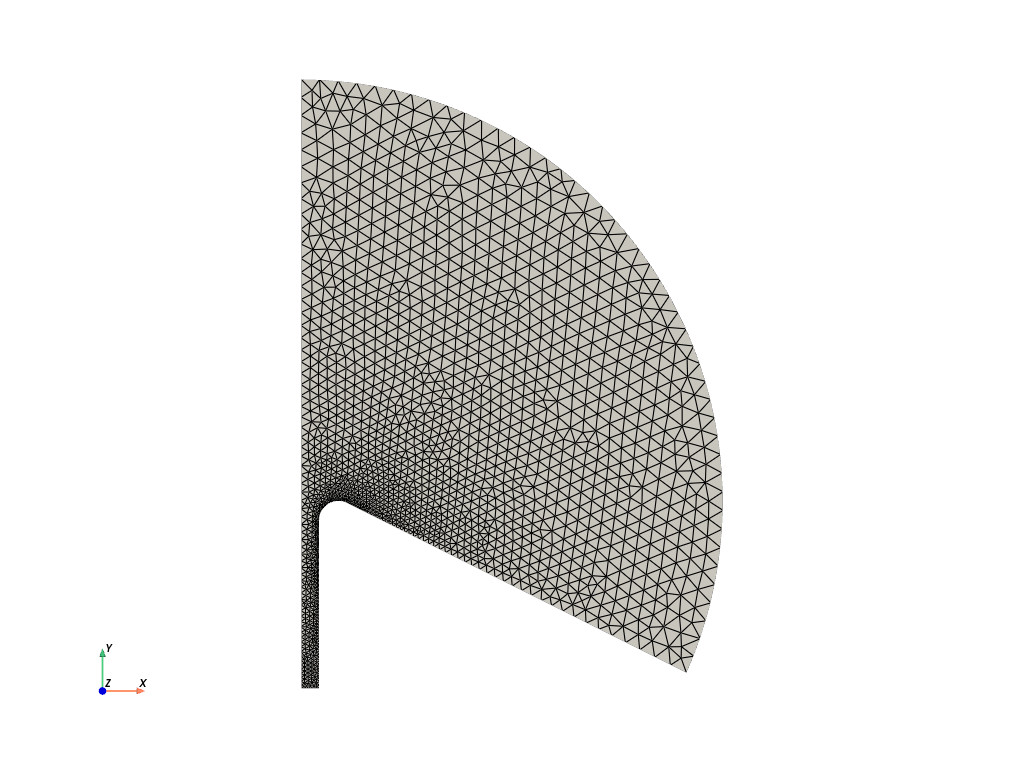

In [39]:
import meshio
import pyvista as pv
import os

print(os.getcwd())

mesh = meshio.read(f"{BASE_PATH}/quail_volcano/scenarios/meshes/tungurahuaA1.msh")

# Clear cell sets to avoid the error
mesh.cell_sets.clear()

# Print mesh details
print("Points:", mesh.points.shape)
print("Cells:", mesh.cells_dict.keys())
#for cell_type, cell_data in mesh.cells_dict.items():
    #print(f"Cell type {cell_type}: {cell_data.shape}")
print("Cell Sets:", mesh.cell_sets)
#print("Cell Data:", mesh.cell_data)

pv.set_jupyter_backend('static')

# Convert to pyvista mesh
pv_mesh = pv.from_meshio(mesh)

# Create a plotter and visualize
plotter = pv.Plotter()

plotter.add_mesh(pv_mesh, show_edges=True, color="white")
plotter.set_scale(xscale=1.0, yscale=1.0, zscale=1.0)
plotter.camera.roll += 80

plotter.view_xy()  # For 2D meshes; use view_isometric() for 3D
plotter.show_axes()
plotter.show()